# COMP90084 Workshop Week 9 - VQC
In this tutorial, we show how to use PennyLane to implement variational
quantum classifiers - quantum circuits that can be trained from labelled
data to classify new data samples. The architecture is inspired by
[Farhi and Neven (2018)](https://arxiv.org/abs/1802.06002) as well as
[Schuld et al. (2018)](https://arxiv.org/abs/1804.00633).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

## Load the Data from the Text File

In [2]:
data = np.loadtxt("iris_classes1and2_scaled.txt")
print("Size of the data: ",data.shape)
X = data[:, [0, 3]] #data[:, 0:4]
Y = data[:,4]
print("First X sample: ", X[0])
print("Label for the first X sample:", Y[0])
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))] if X.shape[1] == 2 else X
# normalize the inputs
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = np.array((X_pad.T/normalization).T, requires_grad=False)
print("First X sample (normalized): ", X_norm[0])
# change -1 in Y to 0
Y_01 = np.array(np.maximum(Y, 0).astype(int), requires_grad=False)
Y_processed = np.zeros((X.shape[0], 2), requires_grad=False)
for i in range(len(Y_01)):
    Y_processed[i, Y_01[i]] = 1
print("Label (processed) for the first X sample:", Y_processed[0])

Size of the data:  (100, 5)
First X sample:  [0.4  0.05]
Label for the first X sample: -1.0
First X sample (normalized):  [0.79602975 0.09950372 0.59702231 0.        ]
Label (processed) for the first X sample: [1. 0.]


## Data Encoding
To encode the data into the amplitudes of a quantum state, we use a 2-qubit simulator. 

State preparation is simple. Every input x has to be translated into a set of angles
which can get fed into a small routine for state preparation. To
simplify things a bit, we will work with data from the positive
subspace, so that we can ignore signs (which would require another
cascade of rotations around the z axis).

The circuit is coded according to the scheme in [Möttönen, et al.
(2004)](https://arxiv.org/abs/quant-ph/0407010), or—as presented for
positive vectors only—in [Schuld and Petruccione
(2018)](https://link.springer.com/book/10.1007/978-3-319-96424-9). 
)

In [3]:
dev = qml.device("default.qubit", wires=2) 
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Test the encoding circuit

In [4]:
test_angles = get_angles(X_norm[0])

@qml.qnode(dev)
def test_(angles):
    statepreparation(angles)
    return qml.expval(qml.PauliZ(0))

test_(test_angles)
print("x               : ", X_norm[0])
print("angles          : ", test_angles)
print("amplitude vector: ", np.real(dev.state))
print(qml.draw(test_)(test_angles))

x               :  [0.79602975 0.09950372 0.59702231 0.        ]
angles          :  [ 1.27956835 -0.          0.         -0.12435499  0.12435499]
amplitude vector:  [0.79602975 0.09950372 0.59702231 0.        ]
0: ──RY(1.28)─╭●────────────╭●──X────────╭●────────────╭●──X────────┤  <Z>
1: ───────────╰X──RY(-0.00)─╰X──RY(0.00)─╰X──RY(-0.12)─╰X──RY(0.12)─┤     


## Variational Layers and Cost Function
In this notebook, we will use the cross entropy between the target and predicted label for our binary classification task. For binary classification, if the predicted label is between 0 and 1, then the crossed entropy between the target $y$ and the predicted $p$ can be calculated as (see https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy):

$$
-[y \log (p)+(1-y) \log (1-p)]
$$

In [9]:
def cross_entropy(y, p):
    loss_array = -y*np.log(p)
    loss_array = np.sum(loss_array, axis=-1)
    return np.mean(loss_array)

def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.probs(wires=0) # sample the probibilities on the first qubit, returns a 2D vector, first element is the probability for |0> and second is for |1>

def variational_classifier(weight, angles):
    return circuit(weight, angles)

def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if l==p:
            acc = acc + 1
    acc = acc / len(labels)

    return acc

def cost(weights, features, labels):
    predictions = np.array([variational_classifier(weights, f) for f in features])
    c = cross_entropy(labels, predictions)
    print("cost: ", c)
    return c

In [7]:

print(qml.draw(circuit)(var_init, test_angles))


0: ──RY(1.28)─╭●────────────╭●──X────────╭●────────────╭●──X─────────Rot(0.00,-0.00,0.01)──╭●
1: ───────────╰X──RY(-0.00)─╰X──RY(0.00)─╰X──RY(-0.12)─╰X──RY(0.12)──Rot(0.01,-0.00,-0.01)─╰X

───Rot(-0.00,-0.01,-0.01)─╭●──Rot(0.00,-0.02,0.00)──╭●──Rot(-0.01,0.00,-0.01)─╭●
───Rot(-0.00,0.01,0.02)───╰X──Rot(-0.01,-0.00,0.00)─╰X──Rot(0.01,0.00,-0.01)──╰X

───Rot(0.01,-0.01,0.02)─╭●──Rot(-0.00,0.01,0.00)─╭●──Rot(0.01,-0.00,0.01)─╭●──Rot(0.01,0.00,-0.01)
───Rot(0.02,-0.01,0.00)─╰X──Rot(0.01,0.01,-0.01)─╰X──Rot(0.00,0.01,0.01)──╰X──Rot(0.02,-0.00,0.00)

──╭●──Rot(0.01,-0.01,0.01)───╭●──Rot(0.01,-0.02,0.02)─╭●─┤  Probs
──╰X──Rot(-0.01,-0.01,-0.00)─╰X──Rot(0.02,0.01,0.01)──╰X─┤       


## Optimization

In [11]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
features = np.array([get_angles(x) for x in X_norm])
feats_train = features[index[:num_train]]
Y_train = Y_processed[index[:num_train]]
Y_01_train = Y_01[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y_processed[index[num_train:]]
Y_01_val = Y_01[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

num_qubits = 2
num_layers = 0
var_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)

opt = qml.NesterovMomentumOptimizer(0.01)
batch_size = 5
early_stop_tol = 1e-3

# train the variational classifier
var = var_init
for it in range(100):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = np.argmax(np.array([variational_classifier(var, f) for f in feats_train]), axis=-1)
    predictions_val =np.argmax(np.array([variational_classifier(var, f) for f in feats_val]), axis=-1)

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_01_train, predictions_train)
    acc_val = accuracy(Y_01_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y_processed), acc_train, acc_val)
    )
    # early stopping
    if abs(acc_train-1)<=early_stop_tol and abs(acc_val-1)<= early_stop_tol:
        print("Early Stop...")
        break

cost:  2.7172017551201804


/home/vscode/.local/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


cost:  2.3677840005864965
Iter:     1 | Cost: 2.3677840 | Acc train: 0.3333333 | Acc validation: 0.3600000 
cost:  1.4932576676242166
cost:  2.3677840005864965
Iter:     2 | Cost: 2.3677840 | Acc train: 0.3333333 | Acc validation: 0.3600000 
cost:  1.9556538410616433
cost:  2.3677840005864965
Iter:     3 | Cost: 2.3677840 | Acc train: 0.3333333 | Acc validation: 0.3600000 
cost:  1.6275574566733346
cost:  2.3677840005864965
Iter:     4 | Cost: 2.3677840 | Acc train: 0.3333333 | Acc validation: 0.3600000 
cost:  1.2825196185805725
cost:  2.3677840005864965
Iter:     5 | Cost: 2.3677840 | Acc train: 0.3333333 | Acc validation: 0.3600000 
cost:  1.894685156316951
cost:  2.3677840005864965
Iter:     6 | Cost: 2.3677840 | Acc train: 0.3333333 | Acc validation: 0.3600000 
cost:  1.720463389557278


KeyboardInterrupt: 

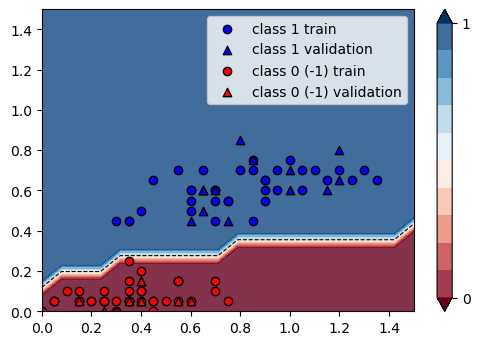

In [ ]:
# We can plot the predictions if we only selectd two columns of X
if X.shape[1] == 2:
    plt.figure()
    cm = plt.cm.RdBu

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    # preprocess grid points like data inputs above
    padding = 0.3 * np.ones((len(X_grid), 1))
    X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
    normalization = np.sqrt(np.sum(X_grid ** 2, -1))
    X_grid = (X_grid.T / normalization).T  # normalize each input
    features_grid = np.array(
        [get_angles(x) for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = np.argmax(np.array([variational_classifier(var, f) for f in features_grid]), axis=-1)
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(0, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[0, 1])

    # plot data
    plt.scatter(
        X_train[:, 0][Y_01_train == 1],
        X_train[:, 1][Y_01_train == 1],
        c="b",
        marker="o",
        edgecolors="k",
        label="class 1 train",
    )
    plt.scatter(
        X_val[:, 0][Y_01_val == 1],
        X_val[:, 1][Y_01_val == 1],
        c="b",
        marker="^",
        edgecolors="k",
        label="class 1 validation",
    )
    plt.scatter(
        X_train[:, 0][Y_01_train == 0],
        X_train[:, 1][Y_01_train == 0],
        c="r",
        marker="o",
        edgecolors="k",
        label="class 0 (-1) train",
    )
    plt.scatter(
        X_val[:, 0][Y_01_val == 0],
        X_val[:, 1][Y_01_val == 0],
        c="r",
        marker="^",
        edgecolors="k",
        label="class 0 (-1) validation",
    )

    plt.legend()
    plt.show()

## Something Else: Cost Function with SWAP Test
$$
P(\text { Control qubit of CSWAP}=0)=\frac{1}{2}(\langle\phi \langle\psi |+\langle\psi|\langle\phi|) \frac{1}{2}(|\phi\rangle|\psi\rangle+|\psi\rangle|\phi\rangle)=\frac{1}{2}+\frac{1}{2}|\langle\psi \mid \phi\rangle|^{2}
$$
Since we've already treated the $1$ class as positive label, the two states we are going to put through the SWAP test will be the $|1\rangle$ state and the output state on the first qubit of the variational classifier. The operator for the measurement of the control qubit of the CSWAP gate will be $|0\rangle\langle 0|$

In [ ]:
boundary = 0.5

dev2 = qml.device("default.qubit", wires=4)

@qml.qnode(dev2)
def circuit2(weights, angles, target_state):
    statepreparation(angles)
    for W in weights:
        layer(W)
    # load target state
    if target_state == 1:
        qml.PauliX(wires=2)
    # swap test between target state and the state of the 0th qubit:
    qml.Hadamard(wires=3)
    qml.CSWAP(wires=[3, 0, 2])
    qml.Hadamard(wires=3)
    return qml.expval(qml.Hermitian(np.outer(np.array([1,0]), np.array([1,0])), wires=[3]))

@qml.qnode(dev2)
def prediction_circuit(weights, angles):
    statepreparation(angles)
    for W in weights:
        layer(W)
    # when making predictions, the default target state is |1>
    # so that the fidelity between the two states for swap test
    # will be zero if the prediction label is 0 and one if 1.
    qml.PauliX(wires=2)
    # swap test between target state and the state of the 0th qubit:
    qml.Hadamard(wires=3)
    qml.CSWAP(wires=[3, 0, 2])
    qml.Hadamard(wires=3)
    return qml.expval(qml.Hermitian(np.outer(np.array([1,0]), np.array([1,0])), wires=[3]))

def prediction_func(weights, features):
    predictions = np.array([prediction_circuit(weights, f) for f in features])
    predictions = (predictions-1/2)*2
    predictions = np.heaviside(predictions-boundary, 0)
    return predictions

# draw the full circuit:
var_draw = 0.01 * np.random.randn(1, 2, 3)
angles_draw = get_angles(X_norm[0])
print(qml.draw(circuit2)(var_draw, angles_draw, 1))

0: ──RY(1.28)─╭●────────────╭●──X────────╭●────────────╭●──X─────────Rot(-0.00,0.02,-0.01)──╭●─╭SWAP
1: ───────────╰X──RY(-0.00)─╰X──RY(0.00)─╰X──RY(-0.12)─╰X──RY(0.12)──Rot(-0.01,-0.00,-0.01)─╰X─│────
2: ──X─────────────────────────────────────────────────────────────────────────────────────────├SWAP
3: ──H─────────────────────────────────────────────────────────────────────────────────────────╰●───

─────┤         
─────┤         
─────┤         
───H─┤  <𝓗(M0)>


In [ ]:
def cost2(weights, features, labels):
    predictions = np.array([circuit2(weights, f, l) for (f, l) in zip(features, labels)])
    # extract the fidelity:
    fid = (predictions-1/2)*2
    loss = 1-fid
    return np.mean(loss)

def accuracy2(labels, predictions):

    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return acc


In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
features = np.array([get_angles(x) for x in X_norm])
feats_train = features[index[:num_train]]
Y_01_train = Y_01[index[:num_train]].astype(int)
feats_val = features[index[num_train:]]
Y_01_val = Y_01[index[num_train:]].astype(int)

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

num_qubits = 2
num_layers = 2
var_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)

opt = qml.AdamOptimizer(0.1)
batch_size = 5
early_stop_tol = 1e-3


# train the variational classifier
var = var_init
for it in range(100):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_01_train[batch_index]
    var = opt.step(lambda v: cost2(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = prediction_func(var, feats_train)
    predictions_val = prediction_func(var, feats_val)

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_01_train, predictions_train)
    acc_val = accuracy(Y_01_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost2(var, features, Y_01), acc_train, acc_val)
    )
    # early stopping
    if abs(acc_train-1)<=early_stop_tol and abs(acc_val-1)<= early_stop_tol:
        print("Early Stop...")
        break

Iter:     1 | Cost: 0.6727288 | Acc train: 0.3333333 | Acc validation: 0.3600000 
Iter:     2 | Cost: 0.6632226 | Acc train: 0.3333333 | Acc validation: 0.3600000 
Iter:     3 | Cost: 0.6520423 | Acc train: 0.3866667 | Acc validation: 0.4000000 
Iter:     4 | Cost: 0.6423658 | Acc train: 0.3866667 | Acc validation: 0.4000000 
Iter:     5 | Cost: 0.6298119 | Acc train: 0.4133333 | Acc validation: 0.4000000 
Iter:     6 | Cost: 0.6164277 | Acc train: 0.4133333 | Acc validation: 0.4000000 
Iter:     7 | Cost: 0.6012761 | Acc train: 0.4533333 | Acc validation: 0.4400000 
Iter:     8 | Cost: 0.5844376 | Acc train: 0.4533333 | Acc validation: 0.4400000 
Iter:     9 | Cost: 0.5658224 | Acc train: 0.4666667 | Acc validation: 0.4400000 
Iter:    10 | Cost: 0.5465429 | Acc train: 0.4666667 | Acc validation: 0.4400000 
Iter:    11 | Cost: 0.5253882 | Acc train: 0.4666667 | Acc validation: 0.4400000 
Iter:    12 | Cost: 0.5031433 | Acc train: 0.5066667 | Acc validation: 0.4400000 
Iter:    13 | Co

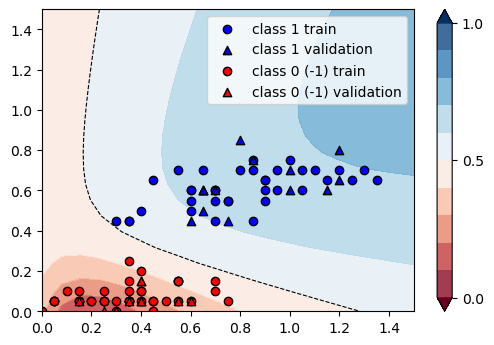

In [ ]:
# We can plot the predictions if we only selectd two columns of X
if X.shape[1] == 2:
    plt.figure()
    cm = plt.cm.RdBu

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    # preprocess grid points like data inputs above
    padding = 0.3 * np.ones((len(X_grid), 1))
    X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
    normalization = np.sqrt(np.sum(X_grid ** 2, -1))
    X_grid = (X_grid.T / normalization).T  # normalize each input
    features_grid = np.array(
        [get_angles(x) for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [(prediction_circuit(var, f)-1/2)*2 for f in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(0, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[boundary], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[0,0.5, 1])

    # plot data
    plt.scatter(
        X_train[:, 0][Y_01_train == 1],
        X_train[:, 1][Y_01_train == 1],
        c="b",
        marker="o",
        edgecolors="k",
        label="class 1 train",
    )
    plt.scatter(
        X_val[:, 0][Y_01_val == 1],
        X_val[:, 1][Y_01_val == 1],
        c="b",
        marker="^",
        edgecolors="k",
        label="class 1 validation",
    )
    plt.scatter(
        X_train[:, 0][Y_01_train == 0],
        X_train[:, 1][Y_01_train == 0],
        c="r",
        marker="o",
        edgecolors="k",
        label="class 0 (-1) train",
    )
    plt.scatter(
        X_val[:, 0][Y_01_val == 0],
        X_val[:, 1][Y_01_val == 0],
        c="r",
        marker="^",
        edgecolors="k",
        label="class 0 (-1) validation",
    )

    plt.legend()
    plt.show()

## Factors that Influence the Loss Landscape and the Best Decision boundary
Batch size, optimizer, number of layers, etc...